# Predicting used car prices

In [ ]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNN

# Data Load

In [ ]:
df1 = pd.read_csv("data/dataset.csv")
df1.head(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Exploratory Data Analysis

In [ ]:
df1.shape

(6019, 14)

In [ ]:
df1.columns

Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
       'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
       'Seats', 'New_Price', 'Price'],
      dtype='object')

In [ ]:
df1["Name"].value_counts() # Explore the various cars in the dataset.

Mahindra XUV500 W8 2WD           49
Maruti Swift VDI                 45
Honda City 1.5 S MT              34
Maruti Swift Dzire VDI           34
Maruti Swift VDI BSIV            31
                                 ..
Ford Fiesta Titanium 1.5 TDCi     1
Mahindra Scorpio S10 AT 4WD       1
Hyundai i20 1.2 Era               1
Toyota Camry W4 (AT)              1
Mahindra Xylo D4 BSIV             1
Name: Name, Length: 1876, dtype: int64

As it appears, there are several cars in the dataset, some of them with a count higher than 1. Sometimes the resale value of a car also depends on manufacturer of car and hence, I'll extract the manufacturer from this column and add it to the dataset.

In [ ]:
make_train = df1["Name"].str.split(" ", expand = True)
df1["Manufacturer"] = make_train[0]

Text(0, 0.5, 'Count of cars')

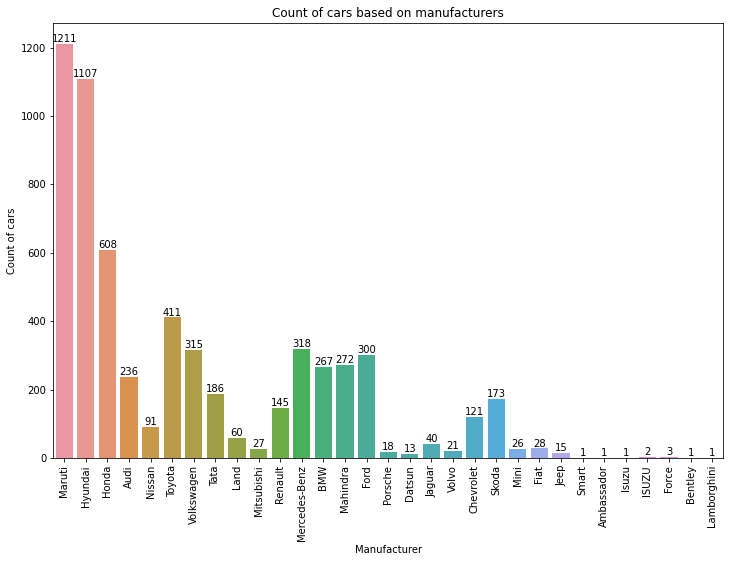

In [ ]:
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = df1)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

Maximum cars in the dataset are by the manufacturer Maruti.

Handle NA values

In [ ]:
df1.isnull().sum()

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
Manufacturer            0
dtype: int64

In [ ]:
# I'll also drop the Name column.
df1.drop("Name", axis = 1, inplace = True) 
# Location should not be a determinant for the price of a car and I'll safely remove it.
df1.drop("Location", axis = 1, inplace = True) 
# Year has no significance on its own unless we try to extract how old a car is from this and see how its resale price may get affected.
curr_time = datetime.datetime.now()
df1['Year'] = df1['Year'].apply(lambda x : curr_time.year - x)
# Kilometers_Driven is a numerical column with a certain range of values.
# This column defines the mileage of the car. We need to extract the numerical value out of each string and save it.
mileage_train = df1["Mileage"].str.split(" ", expand = True)
df1["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
df1["Mileage"].fillna(df1["Mileage"].astype("float64").mean(), inplace = True)

The Engine values are defined in CC so I need to remove CC from the data. Similarly, Power has bhp, so I'll remove bhp from it. Also, as there are missing values in Engine, Power and Seats, I'll again replace them with the mean.

In [ ]:
cc_train = df1["Engine"].str.split(" ", expand = True)
df1["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')

bhp_train = df1["Power"].str.split(" ", expand = True)
df1["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')

In [ ]:
df1["Engine"].fillna(df1["Engine"].astype("float64").mean(), inplace = True)

df1["Power"].fillna(df1["Power"].astype("float64").mean(), inplace = True)

df1["Seats"].fillna(df1["Seats"].astype("float64").mean(), inplace = True)

In [ ]:
# As most of the values are missing, I'll drop this column altogether.
df1.drop(["New_Price"], axis = 1, inplace = True)

In [ ]:
df1.head()

,Unnamed: 0,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer
0,0,12,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,Maruti
1,1,7,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,2,11,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,3,10,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,4,9,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi


In [ ]:
df1.drop(["Unnamed: 0"], axis = 1, inplace = True) # The first column is the index for each data point and hence we can simply remove it.

In [ ]:
df1.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer
0,12,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,Maruti
1,7,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,11,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,10,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,9,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi


In [ ]:
df1.isnull().sum()

Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Manufacturer         0
dtype: int64

In [ ]:
df1.Manufacturer = df1.Manufacturer.apply(lambda x: x.strip())
Manufacturer_stats = df1['Manufacturer'].value_counts(ascending=False)
Manufacturer_stats

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Smart               1
Ambassador          1
Isuzu               1
Bentley             1
Lamborghini         1
Name: Manufacturer, dtype: int64

In [ ]:
len(Manufacturer_stats)

31

In [ ]:
len(Manufacturer_stats[Manufacturer_stats<=10])

7

# Dimensionality Reduction

Any manufacturer having less than 10 data points should be tagged as "other" manufacturer. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [ ]:
Manufacturer_stats_less_than_10 = Manufacturer_stats[Manufacturer_stats<=10]
Manufacturer_stats_less_than_10

Force          3
ISUZU          2
Smart          1
Ambassador     1
Isuzu          1
Bentley        1
Lamborghini    1
Name: Manufacturer, dtype: int64

In [ ]:
df1.Manufacturer = df1.Manufacturer.apply(lambda x: 'other' if x in Manufacturer_stats_less_than_10 else x)

In [ ]:
len(df1.Manufacturer.unique())

25

In [ ]:
df1.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer
0,12,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,Maruti
1,7,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai
2,11,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda
3,10,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti
4,9,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi


In [ ]:
df1.Price.describe()

count    6019.000000
mean        9.479468
std        11.187917
min         0.440000
25%         3.500000
50%         5.640000
75%         9.950000
max       160.000000
Name: Price, dtype: float64

Here we find that min price is 0.44 whereas max is 160, this shows a wide variation in car prices. We should remove outliers per manufaturer using mean and one standard deviation

In [ ]:
df1.shape

(6019, 11)

# Outlier Removal Using Standard Deviation and Mean

In [ ]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Manufacturer'):
        m = np.mean(subdf.Price)
        st = np.std(subdf.Price)
        reduced_df = subdf[(subdf.Price>(m-st)) & (subdf.Price<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df2 = remove_pps_outliers(df1)
df2.shape

(4414, 11)

Text(0, 0.5, 'Count')

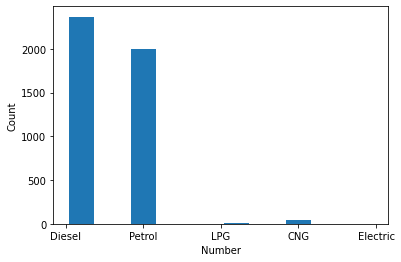

In [ ]:
plt.hist(df2.Fuel_Type,rwidth=0.8)
plt.xlabel("Number")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

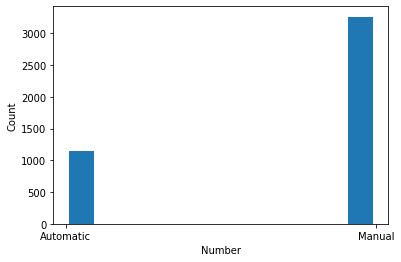

In [ ]:
plt.hist(df2.Transmission,rwidth=0.8)
plt.xlabel("Number")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

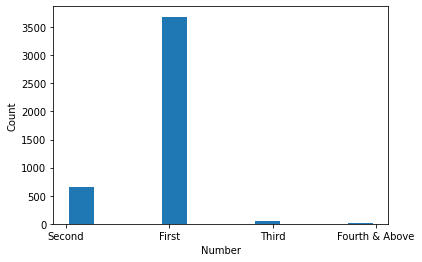

In [ ]:
plt.hist(df2.Owner_Type,rwidth=0.8)
plt.xlabel("Number")
plt.ylabel("Count")

In [ ]:
Other_Fuel_Type = ["LPG","CNG","Electric"]

In [ ]:
df2.Fuel_Type = df2.Fuel_Type.apply(lambda x: 'other' if x in Other_Fuel_Type else x)

Text(0, 0.5, 'Count')

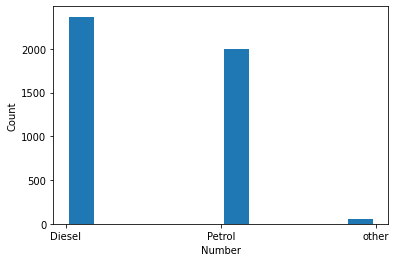

In [ ]:
plt.hist(df2.Fuel_Type,rwidth=0.8)
plt.xlabel("Number")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

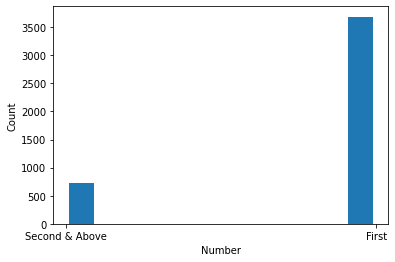

In [ ]:
Other_Owner_Type = ["Second","Third","Fourth & Above"]
df2.Owner_Type = df2.Owner_Type.apply(lambda x: 'Second & Above' if x in Other_Owner_Type else x)
plt.hist(df2.Owner_Type,rwidth=0.8)
plt.xlabel("Number")
plt.ylabel("Count")

Create dummy columns for categorical columns 

In [ ]:
df = pd.get_dummies(df2,columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],drop_first = True)

In [ ]:
df.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Manufacturer_BMW,Manufacturer_Chevrolet,Manufacturer_Datsun,...,Manufacturer_Skoda,Manufacturer_Tata,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Manufacturer_other,Fuel_Type_Petrol,Fuel_Type_other,Transmission_Manual,Owner_Type_Second & Above
0,9,40670,15.20,1968.0,140.80,5.0,17.74,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,7,55985,13.53,1984.0,177.01,5.0,23.50,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,7,13648,17.11,1968.0,174.33,5.0,21.43,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,65664,16.55,1968.0,140.00,5.0,13.50,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,56000,18.53,1968.0,187.74,5.0,29.50,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X = df.drop(['Price'],axis='columns')
X.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Manufacturer_BMW,Manufacturer_Chevrolet,Manufacturer_Datsun,Manufacturer_Fiat,...,Manufacturer_Skoda,Manufacturer_Tata,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Manufacturer_other,Fuel_Type_Petrol,Fuel_Type_other,Transmission_Manual,Owner_Type_Second & Above
0,9,40670,15.20,1968.0,140.80,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,7,55985,13.53,1984.0,177.01,5.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,7,13648,17.11,1968.0,174.33,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,65664,16.55,1968.0,140.00,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,56000,18.53,1968.0,187.74,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y = df.Price
y.head()

0    17.74
1    23.50
2    21.43
3    13.50
4    29.50
Name: Price, dtype: float64

# Training and predicting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

Find best model using GridSearchCV

In [ ]:


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators' : [10,50,100]
            }
        },
        'knn': {
            'model': KNN(n_neighbors=3),
            'params': {
                'n_neighbors' : [1,3,5]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

c:\users\siddhapura_om\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\users\siddhapura_om\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce t

,model,best_score,best_params
0,linear_regression,0.864991,{'normalize': False}
1,lasso,0.674281,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.851086,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
3,random_forest,0.907376,{'n_estimators': 100}
4,knn,0.552457,{'n_neighbors': 5}


In [ ]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
mse(y_pred, y_test)

10.158765102044216

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mse(y_pred, y_test)

11.219759513023783

In [ ]:
rf = RandomForestRegressor(n_estimators = 50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse(y_pred, y_test)

6.87851989208003

In [ ]:
model = keras.Sequential()
model.add(Dense(20, activation='relu', input_shape=[len(X_train.columns)]))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss='mse', metrics=['mse'])
history = model.fit(X_train, y_train, epochs=20, verbose=0)
y_pred = model.predict(X_test)
mse(y_pred,y_test)

29.382498159477425

Test the model for few properties

In [ ]:
model = rf # Final model
def predict_price(m,f,t,o,year,km_driven,mileage,engine,power,seats):    
    loc_index1 = np.where(X_train.columns=="Manufacturer_"+m)[0]
    loc_index2 = np.where(X_train.columns=="Fuel_Type_"+f)[0]
    loc_index3 = np.where(X_train.columns=="Transmission_"+t)[0]
    loc_index4 = np.where(X_train.columns=="Owner_Type_"+o)[0]
    x = np.zeros(len(X_train.columns))
    x[0] = year
    x[1] = km_driven
    x[2] = mileage
    x[3] = engine
    x[4] = power
    x[5] = seats
    if loc_index1 >= 0:
        x[loc_index1] = 1
    if loc_index2 >= 0:
        x[loc_index2] = 1
    if loc_index3 >= 0:
        x[loc_index3] = 1
    if loc_index4 >= 0:
        x[loc_index4] = 1

    return model.predict([x])[0]

In [ ]:
X_test.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Manufacturer_BMW,Manufacturer_Chevrolet,Manufacturer_Datsun,Manufacturer_Fiat,...,Manufacturer_Skoda,Manufacturer_Tata,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Manufacturer_other,Fuel_Type_Petrol,Fuel_Type_other,Transmission_Manual,Owner_Type_Second & Above
3806,5,18351,21.90,624.0,37.48,4.0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2365,8,88500,23.20,1248.0,73.94,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1133,8,66500,26.00,1498.0,98.60,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
413,9,75421,25.44,936.0,56.30,5.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2118,10,56000,12.70,2179.0,187.70,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
predict_price("Tata","Petrol","Auto","First",5,18350,22,625,37.5,4)

C:\Users\SIDDHA~1\AppData\Local\Temp/ipykernel_29716/1643717070.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if loc_index3 >= 0:
C:\Users\SIDDHA~1\AppData\Local\Temp/ipykernel_29716/1643717070.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if loc_index4 >= 0:
c:\users\siddhapura_om\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


3.356

In [ ]:
y_test.head(1)

3806    3.41
Name: Price, dtype: float64

# Export the tested model to a pickle file

In [ ]:
import pickle
with open('used_car_prices_model.pickle','wb') as f:
    pickle.dump(rf,f)

### Export location and column information to a file that will be useful later on in our prediction application

In [ ]:
import json
columns = {
    'data_columns' : [col for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))